[@LorenaABarba](https://twitter.com/LorenaABarba)

[@ggruszczynski](https://github.com/ggruszczynski)

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt   #and the useful plotting library

Diffusion part 1: the fundamental solution
-----
***

The one-dimensional diffusion equation is:

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

The first thing you should notice is that —unlike the previous two simple equations we have studied— this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing $\frac{\partial ^2 u}{\partial x^2}$

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of Forward Difference and Backward Difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

If we add these two expansions, you can see that the odd-numbered derivative terms will cancel each other out.  If we neglect any terms of $O(\Delta x^4)$ or higher (and really, those are very small), then we can rearrange the sum of these two expansions to solve for our second-derivative.  


$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$

Then rearrange to solve for $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ and the result is:

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^4)$$


### Discretizing both $\frac{\partial u}{\partial t}$ and $\frac{\partial ^2 u}{\partial x^2}$

We can now write the discretized version of the diffusion equation in 1D:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation solving for our unknown:

$$u_{i}^{n+1}=u_{i}^{n}+\underbrace{\frac{\nu\Delta t}{\Delta x^2}}_{\beta}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$


$$u_{i}^{n+1}=\beta u_{i-1}^{n} + u_{i}^{n}(1- 2 \beta) +\beta u_{i+1}^{n}$$

The above discrete equation allows us to write a program to advance a solution in time. But we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else. We are ready to number-crunch!

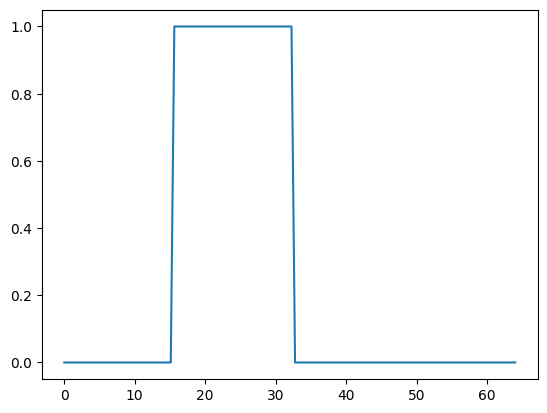

In [2]:
nx = 128
domain_length = 64
dx = domain_length / (nx-1)
xspace = np.linspace(0, domain_length, nx)

nt = 200                # the number of timesteps we want to calculate
nu = 5                  # the value of viscosity
sigma = .2              # sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / nu # dt is defined using sigma ... more later!

u_IC = 0*np.ones(nx)                 # numpy function ones()
u_IC[int((nx-1)/4):int(nx/2 + 1)] = 1 # setting u = 2 between 0.5 and 1 as per our I.C.s

plt.plot(xspace, u_IC)

The time difference is : 0.0014510170003632084


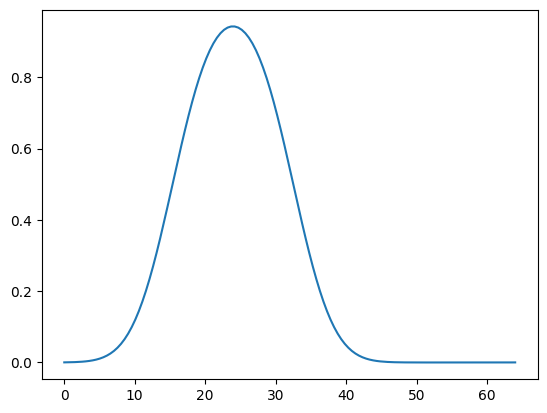

In [3]:
def calc_diffusion_FTCS_naive(IC,nx,nt,nu,dt):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time
    beta = nu * dt / dx**2
    
    for n in range(nt):  #iterate through time
        un = u.copy() #copy the existing values of u into un
        for i in range(0, nx):
            # this is slow (index operations & branching)
            if i == nx-1:
                u[i] = beta*un[i-1]+ (1-2*beta)*un[i] + beta*un[0] # periodic BC
            else:
                u[i] = beta*un[i-1]+ (1-2*beta)*un[i] + beta*un[i+1]
    return u

def calc_diffusion_FTCS(IC,nx,nt,nu,dt):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time
    beta = nu * dt / dx**2

    c_ind = np.arange(0, nx)
    l_ind = np.roll(c_ind, -1)
    r_ind = np.roll(c_ind, 1)
    
    for n in range(nt):  #iterate through time
        un = u.copy() # copy the existing values of u into un
        
        lap_u = un[l_ind] - 2 * un[c_ind] + un[r_ind]  # periodic BC
        u = un + beta* lap_u
    return u


starttime = timeit.default_timer()
u_FD = calc_diffusion_FTCS(u_IC,nx,nt,nu,dt)
print("The time difference is :", timeit.default_timer() - starttime)
plt.plot(xspace, u_FD)

# The convolution - part I 

Repetition:
 - <https://numpy.org/doc/stable/reference/generated/numpy.convolve.html>

 - <https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1>

 - <https://medium.com/ai-salon/understanding-deep-self-attention-mechanism-in-convolution-neural-networks-e8f9c01cb251>

 - <https://en.wikipedia.org/wiki/Convolution>


The discrete convolution operation is known as:

$$ 
(a * v)[n]= \sum^{\infty}_{m=-\infty} a[m]v[n-m]
$$


Notice, that single step of the explicit algorithm implemented before can be expressed as convolution with a $[\beta,1-2 \beta,\beta]$ filter.
To compute more time steps, one have to convolve many times. 

### Task

Solve the diffusion equation by convolving the initial condition with the filter in each iteration.


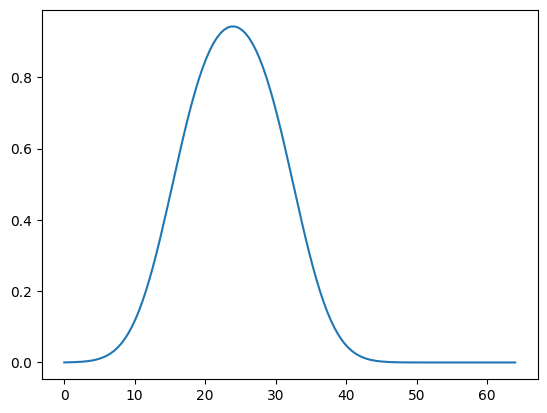

In [4]:
def calc_diffusion_iterate_convolutions(IC,nx,nt,nu,dt):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time
    beta = nu * dt / dx**2
    filtr = np.array([beta,1-2*beta,beta])
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        u = np.convolve(filtr,un, 'same')
    return u

u_iter_conv = calc_diffusion_iterate_convolutions(u_IC,nx,nt,nu,dt)
plt.plot(xspace, u_iter_conv)

# The convolution - part II

The fundamental solution of the heat equation is the Gaussian function (impulse responce).

Consider "diffusion" of a single particle. 
The probability of finding a particle after T time steps follows the normal (a.k.a Gaussian) distribution.
To compute it, one can convolve the initial position with a Gaussian. 
The result will be equivalent with repeated convolutions with small filter.

This means that convolving with a Gaussian tells us the solution to the diffusion equation after
a fixed amount of time. This is the same as low pass filtering an image. So smoothing, low pass
filtering, diffusion, all mean the same thing.


### Task

Solve the diffusion equation by convolving the initial condition with the Gaussian.



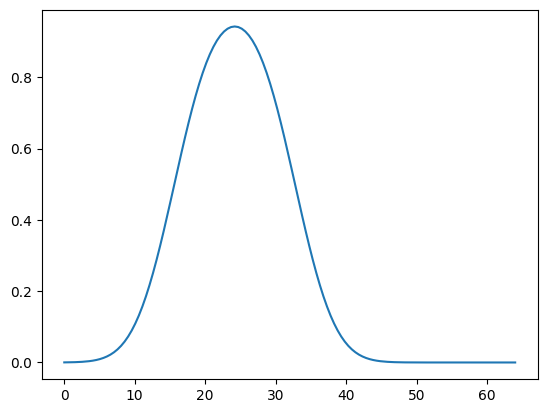

In [5]:
def calc_diffusion_single_convolution(IC,x,nt,nu,dt):
    u = IC.copy()
    def get_gaussian(x, alfa, t):
        g = -(x-domain_length/2.)**2
        g /=(4*alfa*t)
        g = np.exp(g)
        g /= np.sqrt(4*np.pi*alfa*t)
        g *= domain_length/(nx-1) # normalize --> sum(g)=1
        return g
    
    
    time_spot = dt*nt
    fundamental_solution = get_gaussian(x, nu, time_spot)
    
    u = np.convolve(fundamental_solution, u, 'same')
    # plt.plot(x, fundamental_solution, marker='v', linestyle="", markevery=5)
    return u, fundamental_solution

u_single_conv, fs = calc_diffusion_single_convolution(u_IC,xspace,nt,nu,dt)
plt.plot(xspace, u_single_conv)


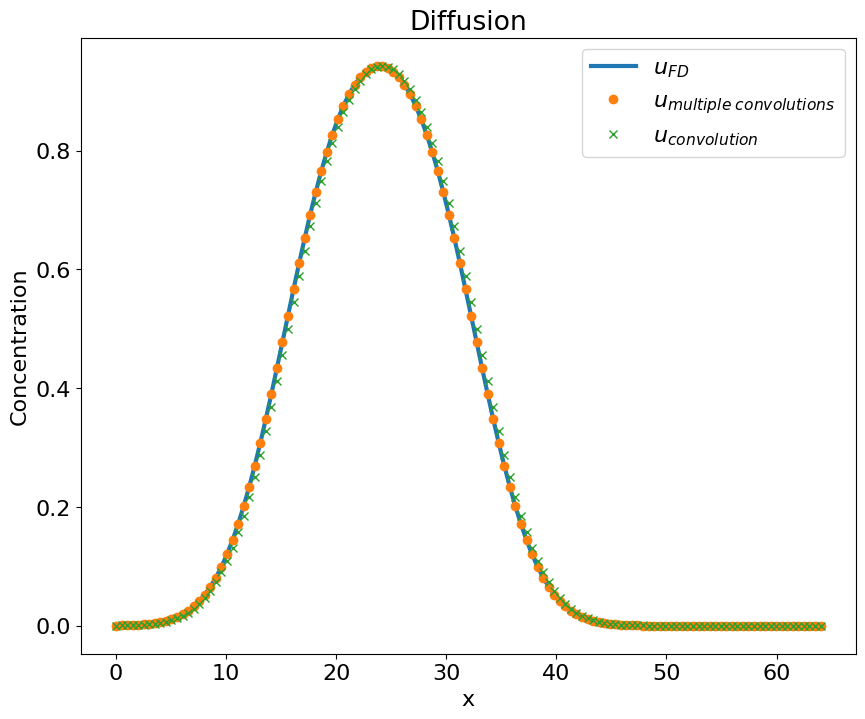

In [6]:
# Now plot the solutions obtained using 3 different approaches on the same plot

plt.rcParams.update({'font.size': 16})
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=1)
axis.set_title('Diffusion')
axis.plot(xspace, u_FD, label=r'$u_{FD}$', linewidth="3")
axis.plot(xspace, u_iter_conv, label=r'$u_{multiple \; convolutions}$',  marker='o', linestyle="", markevery=1)
axis.plot(xspace, u_single_conv, label=r'$u_{convolution}$', marker='x', linestyle="", markevery=1)
axis.set_xlabel('x')
axis.set_ylabel('Concentration')
axis.legend(loc="upper right")

# Analytical solution: Advection - Diffusion of a Gaussian Hill

In case of an isotropic diffusion, the analytical solution describing evolution of a Gaussian Hill can be expressed as 

$$
C(\boldsymbol{x}, t)=\frac{\left(2\pi\sigma_{0}^{2}\right)^{D/2} }{\left(2\pi(\sigma_{0}^{2} + 2 k t)\right)^{D/2}} 
C_0 \exp \left(-\frac{\left(\boldsymbol{x}-\boldsymbol{x}_{0}-\boldsymbol{u} t\right)^{2}}{2\left(\sigma_{0}^{2}+ 2 k t\right)}\right)
$$

where:

* $C_0$ - initial concentration,
* $D$ - number of dimensions, 
* $t$ - time, 
* $k$ - conductivity, 
* $\boldsymbol{u}$ - velocity of advection
* $\sigma_{0}$ the initial variance of the distribution.

## Task

1) Implement the `GaussianHillAnal` class. 
It shall have a method `get_concentration_ND(self, X, t)`, which will return the concentration at given time and space.

2) Benchmark the FD code against analytical solution.

In [7]:
from sympy.matrices import Matrix
import sympy as sp

class GaussianHillAnal:
    def __init__(self, C0, X0, Sigma2_0, k, U, D):
        """
        :param C0: initial concentration
        :param X0: initial position of the hill's centre = Matrix([x0, y0])
        :param U:  velocity = Matrix([ux, uy])
        :param Sigma2_0: initial width of the Gaussian Hill
        :param k: conductivity
        :param dimenions: number of dimensions
        """
        self.C0 = C0
        self.X0 = X0
        self.U = U
        self.Sigma2_0 = Sigma2_0
        self.k = k
        self.dim = D

    def get_concentration_ND(self, X, t):
        decay = 2.*self.k*t
        L = X - self.X0 - self.U*t
        C = self.C0
        C *= pow(2. * np.pi * self.Sigma2_0, self.dim / 2.)
        C /= pow(2. * np.pi * (self.Sigma2_0 + decay), self.dim / 2.)
        C *= sp.exp(-(L.dot(L)) / (2.*(self.Sigma2_0 + decay)))
        return C



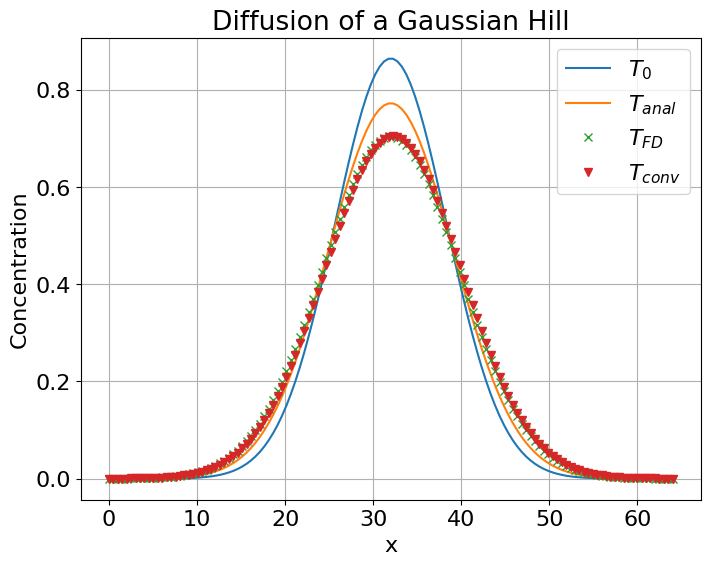

In [8]:
time_0    = dt*nt/2     # initial contidion for FD
time_spot = dt*nt       # time to be simulated (by FD and analytically)

X0 = Matrix([domain_length/2.]) # center of the hill
C0 = 1.                 # concentration
variance = 30           # initial variance
reference_level = 0     

T_0 = np.zeros(nx)
T_anal = np.zeros(nx)

gha = GaussianHillAnal(C0, X0, variance, nu, Matrix([0]), D=1)

for i in range(nx):
    T_0[i] = reference_level + gha.get_concentration_ND(Matrix([xspace[i]]), time_0)  
    T_anal[i] = reference_level + gha.get_concentration_ND(Matrix([xspace[i]]), time_spot)  

T_FD = calc_diffusion_FTCS(T_0,nx,nt,nu,dt)
T_single_conv, fs = calc_diffusion_single_convolution(T_0,xspace,nt,nu,dt)

plt.rcParams.update({'font.size': 16})
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=1)
axis.set_title('Diffusion of a Gaussian Hill')
axis.plot(xspace, T_0, label=r'$T_{0}$')
axis.plot(xspace, T_anal, label=r'$T_{anal}$')
axis.plot(xspace, T_FD, label=r'$T_{FD}$', marker='x', linestyle="", markevery=1)
axis.plot(xspace, T_single_conv, label=r'$T_{conv}$', marker='v', linestyle="", markevery=1)
axis.set_xlabel('x')
axis.set_ylabel('Concentration')
axis.legend(loc="upper right")
plt.grid()

## Questions:

* How do you find the FD solution compared to analytical one? Experiment with different dx, dt.

* How would you asses that your mesh is fine enought in a real CFD simulation (without analytical solution)? 

## Answers

* Mesh convergence study

# Learn More

Inspiration

<http://www.cs.umd.edu/~djacobs/CMSC828seg/Diffusion.pdf>

<https://web.math.ucsb.edu/~helena/teaching/math124b/heat.pdf>

You should have completed Steps [1](./01_Step_1.ipynb) and [2](./02_Step_2.ipynb) before continuing. This Jupyter notebook continues the presentation of the **12 steps to Navier–Stokes**, the practical module taught in the interactive CFD class of [Prof. Lorena Barba](http://lorenabarba.com). 

For a careful walk-through of the discretization of the diffusion equation with finite differences (and all steps from 1 to 4), watch **Video Lesson 4** by Prof. Barba on YouTube.

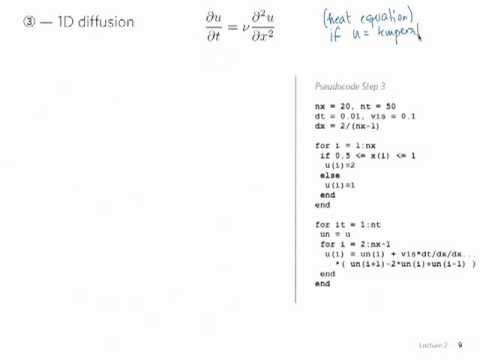

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('y2WaK7_iMRI')